In [60]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import percentileofscore

from battleship.scoring import compute_score, compute_score_parallel
from battleship.prompting import HUMAN_DATASET_PATH
from battleship.board import Board

# Configure matplotlib for retina display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Configure seaborn
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.25)

In [61]:
RESULTS_DIR = "results_official"
FIGURES_DIR = "figures"

# Load the data

In [62]:
HUMAN_DATA_PATH = os.path.join(RESULTS_DIR, "human_question_dataset_scored.csv")

# Compute scores if they don't exist
if not os.path.exists(HUMAN_DATA_PATH):
    df_human = pd.read_csv(HUMAN_DATASET_PATH)
    df_human["score"] = [
        compute_score(program=program, board=Board.from_trial_id(trial_id))
        for program, trial_id in zip(df_human["code"], df_human["trial"])
    ]
    df_human["model"] = "Human"
    df_human.to_csv(HUMAN_DATA_PATH, index=False)
else:
    df_human = pd.read_csv(HUMAN_DATA_PATH)

df_human = df_human.rename(columns={"trial": "trial_id", "code": "program"})
df_human

trial_id                                           question  \
0           1                          Are all ships horizontal?   
1           1                     Are any of the ships touching?   
2           1                        Are any ships 2 tiles long?   
3           1  At what location is the top left part of the r...   
4           1  At what location is the top left part of the r...   
..        ...                                                ...   
600        18                      Is there a purple tile at 1A?   
601        18                      Is there a purple tile at 2C?   
602        18  Is there any part of the purple ship in column B?   
603        18                               What color is at 1A?   
604        18                               What color is at 3A?   

                                               program     score  model  
0    (all (map (lambda x0 (== (orient x0) H)) (set ...  0.470937  Human  
1    (or (or (touch Blue Purple) (touch Purple Red)...  0.988805  Human  
2    (any (map (lambda x0 (== (size x0) 2)) (set Al...  0.378446  Human  
3                         (topleft (coloredTiles Red))  4.669496  Human  
4                         (topleft (coloredTiles Red))  4.669496  Human  
..                                                 ...       ...    ...  
600                             (== (color 1A) Purple)  0.954434  Human  
601                             (== (color 2C) Purple)  0.811278  Human  
602  (any (map (lambda y0 (== (colL y0) 2)) (colore...  0.954434  Human  
603                                         (color 1A)  0.954434  Human  
604                                         (color 3A)  1.000000  Human  

[605 rows x 5 columns]

In [63]:
df_codellama_7b = pd.read_csv(os.path.join(RESULTS_DIR, "CodeLlama-7b-hf-2024-01-23-04-52-40", "results_corrected.csv"))
df_codellama_7b["model"] = "CodeLlama-7b"
# rename completion -> question and translation -> program
df_codellama_7b = df_codellama_7b.rename(columns={"completion": "question", "translation": "program"})
df_codellama_7b

trial_id                            question  \
0            1  How many tiles is the purple ship?   
1            1                What color is at 2F?   
2            1         Is the red ship horizontal?   
3            1        Is there a water tile at 3D?   
4            1              Is there a ship at 2F?   
...        ...                                 ...   
1795        18                What color is at 1B?   
1796        18    Is the purple ship 4 tiles long?   
1797        18                What color is at 5B?   
1798        18    How many tiles is the blue ship?   
1799        18              Is there a ship at 3F?   

                                                program     score   type  \
0                                         (size Purple)  1.360775  final   
1                                            (color 2F)  1.418245  final   
2                                   (== (orient Red) H)  0.993542  final   
3                                 (== (color 3D) Water) -0.000000  final   
4                                            (color 2F)  1.418245  final   
...                                                 ...       ...    ...   
1795                                           (at 1 B)       NaN  final   
1796                               (== (size Purple) 4)  0.811278  final   
1797                                            (at 5B)       NaN  final   
1798                                        (size Blue) -0.000000  final   
1799  (any (map (lambda x0 (== (coord x0) 3F)) (set ...       NaN  final   

      prompt_id         model  
0             0  CodeLlama-7b  
1             0  CodeLlama-7b  
2             0  CodeLlama-7b  
3             0  CodeLlama-7b  
4             0  CodeLlama-7b  
...         ...           ...  
1795         19  CodeLlama-7b  
1796         19  CodeLlama-7b  
1797         19  CodeLlama-7b  
1798         19  CodeLlama-7b  
1799         19  CodeLlama-7b  

[1800 rows x 7 columns]

In [64]:
df_gpt4_textual = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-25-15-02-02-textual", "results.csv"))
df_gpt4_textual["model"] = "GPT-4 (textual, few-shot)"
df_gpt4_textual["board_format"] = "textual"
df_gpt4_textual["few_shot"] = True

df_gpt4_textual_zero_shot = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-00-48-40-textual-zero-shot", "results.csv"))
df_gpt4_textual_zero_shot["model"] = "GPT-4 (textual, zero-shot)"
df_gpt4_textual_zero_shot["board_format"] = "textual"
df_gpt4_textual_zero_shot["few_shot"] = False

df_gpt4_grid = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-01-27-01-grid", "results.csv"))
df_gpt4_grid["model"] = "GPT-4 (grid, few-shot)"
df_gpt4_grid["board_format"] = "grid"
df_gpt4_grid["few_shot"] = True

df_gpt4_grid_zero_shot = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-02-02-26-grid-zero-shot", "results.csv"))
df_gpt4_grid_zero_shot["model"] = "GPT-4 (grid, zero-shot)"
df_gpt4_grid_zero_shot["board_format"] = "grid"
df_gpt4_grid_zero_shot["few_shot"] = False

# df_gpt4_visual = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-20-08-00-visual", "results.csv"))
df_gpt4_visual = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-27-23-44-54-visual", "results.csv"))
df_gpt4_visual["model"] = "GPT-4 (visual, few-shot)"
df_gpt4_visual["board_format"] = "visual"
df_gpt4_visual["few_shot"] = True

df_gpt4_visual_zero_shot = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-21-15-00-visual-zero-shot", "results.csv"))
df_gpt4_visual_zero_shot["model"] = "GPT-4 (visual, zero-shot)"
df_gpt4_visual_zero_shot["board_format"] = "visual"
df_gpt4_visual_zero_shot["few_shot"] = False

In [65]:
# df_grammar_sampling = pd.read_csv(os.path.join(RESULTS_DIR, "grammar-sampling-2024-01-22", "sampling_data.csv"))
df_grammar_sampling_1 = pd.read_csv(os.path.join(RESULTS_DIR, "grammar-sampling-2024-01-29", "sampling_data_min_depth_1.csv"))
df_grammar_sampling_3 = pd.read_csv(os.path.join(RESULTS_DIR, "grammar-sampling-2024-01-29", "sampling_data_min_depth_3.csv"))

df_grammar_sampling_1["model"] = "Grammar"
df_grammar_sampling_3["model"] = "Grammar (min depth 3)"

assert (df_grammar_sampling_1["min_depth"] == 1).all()
assert (df_grammar_sampling_3["min_depth"] == 3).all()

df_grammar_sampling = pd.concat([df_grammar_sampling_1, df_grammar_sampling_3]).reset_index(drop=True)
df_grammar_sampling = df_grammar_sampling.drop(columns=["Unnamed: 0"])

# df_grammar_sampling = df_grammar_sampling.rename(columns={"board_id": "trial_id"})
# df_grammar_sampling = df_grammar_sampling[["trial_id", "program", "score", "depth"]]

df_grammar_sampling

program  trial_id  \
0                                                       2B         1   
1                                 ( == V ( orient Blue ) )         1   
2                         ( and ( == Water Water ) FALSE )         1   
3                                                       6D         1   
4                      ( and ( touch Red Red ) ( > 9 3 ) )         1   
...                                                    ...       ...   
3599995  ( == ( or ( > 1 ( setSize ( unique ( set AllTi...        18   
3599996  ( == ( touch Red Purple ) ( == ( not ( == 9 ( ...        18   
3599997                           ( == ( orient Blue ) H )        18   
3599998          ( setSize ( coloredTiles ( color 3F ) ) )        18   
3599999    ( < ( + ( rowL 5C ) ( colL 5B ) ) ( rowL 1D ) )        18   

            score  depth  min_depth  max_depth                  model  
0       -0.000000      1          1         16                Grammar  
1        0.993542      3          1         16                Grammar  
2       -0.000000      3          1         16                Grammar  
3       -0.000000      1          1         16                Grammar  
4       -0.000000      3          1         16                Grammar  
...           ...    ...        ...        ...                    ...  
3599995 -0.000000      7          3         16  Grammar (min depth 3)  
3599996 -0.000000      6          3         16  Grammar (min depth 3)  
3599997 -0.000000      3          3         16  Grammar (min depth 3)  
3599998 -0.000000      4          3         16  Grammar (min depth 3)  
3599999  1.561278      4          3         16  Grammar (min depth 3)  

[3600000 rows x 7 columns]

In [66]:
# df_grammar_enumeration = pd.read_csv(os.path.join(RESULTS_DIR, "grammar-enumeration-2024-01-22", "enumeration_data.csv"))
# df_grammar_enumeration = df_grammar_enumeration.rename(columns={"board_id": "trial_id"})
# df_grammar_enumeration = df_grammar_enumeration[["trial_id", "program", "score"]]
# df_grammar_enumeration["model"] = "Grammar (enumeration)"

# # # Pretend that we only sampled 100 programs per trial
# # df_grammar_enumeration = df_grammar_enumeration.groupby("trial_id").head(100)

# df_grammar_enumeration

# Construct bootstrapped k samples

In [67]:
BOOTSTRAP_MODELS = [
    df_codellama_7b,
    df_gpt4_textual_zero_shot,
    df_gpt4_textual,
    df_gpt4_grid_zero_shot,
    df_gpt4_grid,
    df_gpt4_visual_zero_shot,
    df_gpt4_visual,
    df_grammar_sampling,
    # df_grammar_enumeration,
]


def bootstrap(df: pd.DataFrame, k: int = 5):
    """Splits the data into chunks of size k and returns the single highest-scoring row from each chunk."""
    _scores = df["score"].to_numpy()
    n = len(_scores)
    _scores = np.nan_to_num(_scores, nan=float("-inf"))
    _scores = np.reshape(_scores, (-1, k))
    idx = np.argmax(_scores, axis=1)
    offset = np.array([i * k for i in range(len(idx))])
    idx = idx + offset
    _df = df.iloc[idx].reset_index(drop=True)
    return _df


data = []

for _df_model in BOOTSTRAP_MODELS:
    # k=1
    _df = _df_model
    _df["k"] = 1
    data.append(_df)
    # k > 1
    for k in [5, 10, 20, 50]:
        # _df = _df_model.groupby(["model", "trial_id"]).apply(lambda df: bootstrap(df, k=k)).reset_index(drop=True)
        for trial_id, df_group in _df_model.groupby("trial_id"):
            if len(df_group) < k:
                continue

            _df = bootstrap(df_group.copy(), k=k)
            _df["k"] = k
            data.append(_df)

df_bootstrapped = pd.concat(data).reset_index(drop=True)
df_bootstrapped

trial_id                            question  \
0               1  How many tiles is the purple ship?   
1               1                What color is at 2F?   
2               1         Is the red ship horizontal?   
3               1        Is there a water tile at 3D?   
4               1              Is there a ship at 2F?   
...           ...                                 ...   
4949257        18                                 NaN   
4949258        18                                 NaN   
4949259        18                                 NaN   
4949260        18                                 NaN   
4949261        18                                 NaN   

                                                   program     score   type  \
0                                            (size Purple)  1.360775  final   
1                                               (color 2F)  1.418245  final   
2                                      (== (orient Red) H)  0.993542  final   
3                                    (== (color 3D) Water) -0.000000  final   
4                                               (color 2F)  1.418245  final   
...                                                    ...       ...    ...   
4949257  ( and ( > 5 3 ) ( == ( == ( colL 5C ) 4 ) ( ==...  0.954434    NaN   
4949258                       ( setSize ( set AllTiles ) )  0.954434    NaN   
4949259             ( bottomright ( coloredTiles Water ) )  1.000000    NaN   
4949260  ( + ( - ( - ( - 3 6 ) ( rowL 2F ) ) ( colL 6E ...  1.000000    NaN   
4949261                         ( == Purple ( color 4F ) )  1.561278    NaN   

         prompt_id                  model   k board_format few_shot  depth  \
0              0.0           CodeLlama-7b   1          NaN      NaN    NaN   
1              0.0           CodeLlama-7b   1          NaN      NaN    NaN   
2              0.0           CodeLlama-7b   1          NaN      NaN    NaN   
3              0.0           CodeLlama-7b   1          NaN      NaN    NaN   
4              0.0           CodeLlama-7b   1          NaN      NaN    NaN   
...            ...                    ...  ..          ...      ...    ...   
4949257        NaN  Grammar (min depth 3)  50          NaN      NaN    5.0   
4949258        NaN  Grammar (min depth 3)  50          NaN      NaN    3.0   
4949259        NaN  Grammar (min depth 3)  50          NaN      NaN    3.0   
4949260        NaN  Grammar (min depth 3)  50          NaN      NaN    6.0   
4949261        NaN  Grammar (min depth 3)  50          NaN      NaN    3.0   

         min_depth  max_depth  
0              NaN        NaN  
1              NaN        NaN  
2              NaN        NaN  
3              NaN        NaN  
4              NaN        NaN  
...            ...        ...  
4949257        3.0       16.0  
4949258        3.0       16.0  
4949259        3.0       16.0  
4949260        3.0       16.0  
4949261        3.0       16.0  

[4949262 rows x 13 columns]

# Merge datasets

In [77]:
COLOR_TEXTUAL = "#223843"
COLOR_GRID = "#466A7C"
COLOR_VISUAL = "#6A9BB4"

PALETTE = {
    "Human": "#55A868",
    "CodeLlama-7b": "#17C3B2",
    "GPT-4 (textual, few-shot)": COLOR_TEXTUAL,
    "GPT-4 (textual, zero-shot)": COLOR_TEXTUAL,
    "GPT-4 (grid, few-shot)": COLOR_GRID,
    "GPT-4 (grid, zero-shot)": COLOR_GRID,
    "GPT-4 (visual, few-shot)": COLOR_VISUAL,
    "GPT-4 (visual, zero-shot)": COLOR_VISUAL,
    "Grammar": "#D77A61",
    "Grammar (min depth 3)": "#E39F8C",
}

In [78]:
df = pd.concat([df_human, df_bootstrapped]).reset_index(drop=True)
df["k"] = df["k"].fillna(1).astype(int)
df

trial_id                                           question  \
0               1                          Are all ships horizontal?   
1               1                     Are any of the ships touching?   
2               1                        Are any ships 2 tiles long?   
3               1  At what location is the top left part of the r...   
4               1  At what location is the top left part of the r...   
...           ...                                                ...   
4949862        18                                                NaN   
4949863        18                                                NaN   
4949864        18                                                NaN   
4949865        18                                                NaN   
4949866        18                                                NaN   

                                                   program     score  \
0        (all (map (lambda x0 (== (orient x0) H)) (set ...  0.470937   
1        (or (or (touch Blue Purple) (touch Purple Red)...  0.988805   
2        (any (map (lambda x0 (== (size x0) 2)) (set Al...  0.378446   
3                             (topleft (coloredTiles Red))  4.669496   
4                             (topleft (coloredTiles Red))  4.669496   
...                                                    ...       ...   
4949862  ( and ( > 5 3 ) ( == ( == ( colL 5C ) 4 ) ( ==...  0.954434   
4949863                       ( setSize ( set AllTiles ) )  0.954434   
4949864             ( bottomright ( coloredTiles Water ) )  1.000000   
4949865  ( + ( - ( - ( - 3 6 ) ( rowL 2F ) ) ( colL 6E ...  1.000000   
4949866                         ( == Purple ( color 4F ) )  1.561278   

                         model type  prompt_id   k board_format few_shot  \
0                        Human  NaN        NaN   1          NaN      NaN   
1                        Human  NaN        NaN   1          NaN      NaN   
2                        Human  NaN        NaN   1          NaN      NaN   
3                        Human  NaN        NaN   1          NaN      NaN   
4                        Human  NaN        NaN   1          NaN      NaN   
...                        ...  ...        ...  ..          ...      ...   
4949862  Grammar (min depth 3)  NaN        NaN  50          NaN      NaN   
4949863  Grammar (min depth 3)  NaN        NaN  50          NaN      NaN   
4949864  Grammar (min depth 3)  NaN        NaN  50          NaN      NaN   
4949865  Grammar (min depth 3)  NaN        NaN  50          NaN      NaN   
4949866  Grammar (min depth 3)  NaN        NaN  50          NaN      NaN   

         depth  min_depth  max_depth  
0          NaN        NaN        NaN  
1          NaN        NaN        NaN  
2          NaN        NaN        NaN  
3          NaN        NaN        NaN  
4          NaN        NaN        NaN  
...        ...        ...        ...  
4949862    5.0        3.0       16.0  
4949863    3.0        3.0       16.0  
4949864    3.0        3.0       16.0  
4949865    6.0        3.0       16.0  
4949866    3.0        3.0       16.0  

[4949867 rows x 13 columns]

# EIG comparison

### Summary stats

In [79]:
aggregators = {
    "score": [
        ("mean", lambda x: x.mean()),
        ("valid", lambda x: x.count() / len(x)),
        ("nonzero", lambda x: (x > 0).sum() / len(x)),
        ("count", lambda x: len(x)),
    ],
    "question": [
        ("question_length", lambda x: x.str.len().mean()),
    ]
}

df_grouped_by_trial = df.groupby(["trial_id", "model", "k"]).agg(aggregators)
df_grouped_by_trial.columns = df_grouped_by_trial.columns.droplevel(0)
df_grouped_by_trial

mean  valid   nonzero  count  \
trial_id model                 k                                      
1        CodeLlama-7b          1   1.122182   0.72  0.620000    100   
                               5   1.730785   1.00  1.000000     20   
                               10  2.373790   1.00  1.000000     10   
                               20  2.725061   1.00  1.000000      5   
                               50  4.669496   1.00  1.000000      2   
...                                     ...    ...       ...    ...   
18       Grammar (min depth 3) 5   0.449804   1.00  0.407050  20000   
                               10  0.746503   1.00  0.647600  10000   
                               20  1.088923   1.00  0.874600   5000   
                               50  1.466783   1.00  0.994500   2000   
         Human                 1   1.078188   1.00  0.972222     36   

                                   question_length  
trial_id model                 k                    
1        CodeLlama-7b          1         29.870000  
                               5         31.250000  
                               10        34.700000  
                               20        32.800000  
                               50        55.000000  
...                                            ...  
18       Grammar (min depth 3) 5               NaN  
                               10              NaN  
                               20              NaN  
                               50              NaN  
         Human                 1         33.111111  

[828 rows x 5 columns]

In [80]:
df_main_results = df_grouped_by_trial.groupby(["model", "k"])[
    ["mean", "valid", "nonzero", "count", "question_length"]
].agg(["mean", "std"])
# flatten multiindex
df_main_results.columns = [
    col[1] if col[1] == "std" else col[0] for col in df_main_results.columns
]
df_main_results = df_main_results.round(3)
df_main_results

mean    std  valid    std  nonzero    std  \
model                      k                                                
CodeLlama-7b               1   0.657  0.237  0.747  0.037    0.447  0.122   
                           5   1.242  0.291  0.989  0.027    0.903  0.087   
                           10  1.549  0.366  0.994  0.024    0.972  0.046   
                           20  1.833  0.460  1.000  0.000    1.000  0.000   
                           50  2.308  0.941  1.000  0.000    1.000  0.000   
GPT-4 (grid, few-shot)     1   0.637  0.367  0.848  0.133    0.486  0.275   
                           5   0.999  0.417  0.961  0.063    0.772  0.296   
                           10  1.180  0.437  0.994  0.024    0.867  0.257   
                           20  1.380  0.438  1.000  0.000    0.922  0.156   
                           50  1.636  0.608  1.000  0.000    1.000  0.000   
GPT-4 (grid, zero-shot)    1   0.566  0.166  0.549  0.104    0.392  0.132   
                           5   0.785  0.120  0.878  0.089    0.797  0.117   
                           10  0.888  0.096  0.961  0.078    0.933  0.084   
                           20  0.943  0.070  1.000  0.000    1.000  0.000   
                           50  0.995  0.090  1.000  0.000    1.000  0.000   
GPT-4 (textual, few-shot)  1   0.782  0.337  0.877  0.082    0.589  0.231   
                           5   1.163  0.355  0.981  0.025    0.864  0.185   
                           10  1.432  0.372  1.000  0.000    0.967  0.077   
                           20  1.648  0.451  1.000  0.000    1.000  0.000   
                           50  2.035  0.962  1.000  0.000    1.000  0.000   
GPT-4 (textual, zero-shot) 1   0.659  0.245  0.397  0.078    0.351  0.086   
                           5   0.748  0.246  0.597  0.127    0.544  0.136   
                           10  0.794  0.231  0.767  0.119    0.728  0.118   
                           20  0.829  0.218  0.922  0.100    0.878  0.100   
                           50  0.918  0.154  1.000  0.000    1.000  0.000   
GPT-4 (visual, few-shot)   1   0.539  0.296  0.799  0.153    0.457  0.270   
                           5   0.894  0.284  0.914  0.110    0.753  0.211   
                           10  1.080  0.249  0.989  0.032    0.917  0.120   
                           20  1.289  0.282  1.000  0.000    0.978  0.065   
                           50  1.557  0.496  1.000  0.000    1.000  0.000   
GPT-4 (visual, zero-shot)  1   0.335  0.248  0.582  0.063    0.246  0.145   
                           5   0.727  0.321  0.700  0.017    0.556  0.141   
                           10  0.878  0.322  0.800  0.000    0.706  0.116   
                           20  0.986  0.343  1.000  0.000    0.922  0.122   
                           50  1.191  0.384  1.000  0.000    1.000  0.000   
Grammar                    1   0.209  0.050  0.999  0.000    0.204  0.046   
                           5   0.754  0.144  1.000  0.000    0.649  0.098   
                           10  1.117  0.182  1.000  0.000    0.852  0.080   
                           20  1.485  0.216  1.000  0.000    0.963  0.040   
                           50  1.947  0.289  1.000  0.000    0.997  0.007   
Grammar (min depth 3)      1   0.209  0.049  0.997  0.000    0.208  0.047   
                           5   0.771  0.141  1.000  0.000    0.679  0.101   
                           10  1.153  0.174  1.000  0.000    0.887  0.076   
                           20  1.542  0.206  1.000  0.000    0.981  0.029   
                           50  2.055  0.288  1.000  0.000    1.000  0.001   
Human                      1   1.274  0.172  1.000  0.000    0.966  0.028   

                                    count    std  question_length    std  
model                      k                                              
CodeLlama-7b               1      100.000  0.000           30.102  0.809  
                           5       20.000  0.000           30.925  1.888  
                           10      

In [81]:
# convert to markdown
print(df_main_results.reset_index().to_markdown(index=False))

| model                      |   k |   mean |   std |   valid |   std |   nonzero |   std |      count |   std |   question_length |     std |
|:---------------------------|----:|-------:|------:|--------:|------:|----------:|------:|-----------:|------:|------------------:|--------:|
| CodeLlama-7b               |   1 |  0.657 | 0.237 |   0.747 | 0.037 |     0.447 | 0.122 |    100     | 0     |            30.102 |   0.809 |
| CodeLlama-7b               |   5 |  1.242 | 0.291 |   0.989 | 0.027 |     0.903 | 0.087 |     20     | 0     |            30.925 |   1.888 |
| CodeLlama-7b               |  10 |  1.549 | 0.366 |   0.994 | 0.024 |     0.972 | 0.046 |     10     | 0     |            32.611 |   3.059 |
| CodeLlama-7b               |  20 |  1.833 | 0.46  |   1     | 0     |     1     | 0     |      5     | 0     |            35.033 |   4.843 |
| CodeLlama-7b               |  50 |  2.308 | 0.941 |   1     | 0     |     1     | 0     |      2     | 0     |            39.694 |   7.874 |

### Overall EIG distributions

In [82]:
df_1 = df[df["k"] == 1]

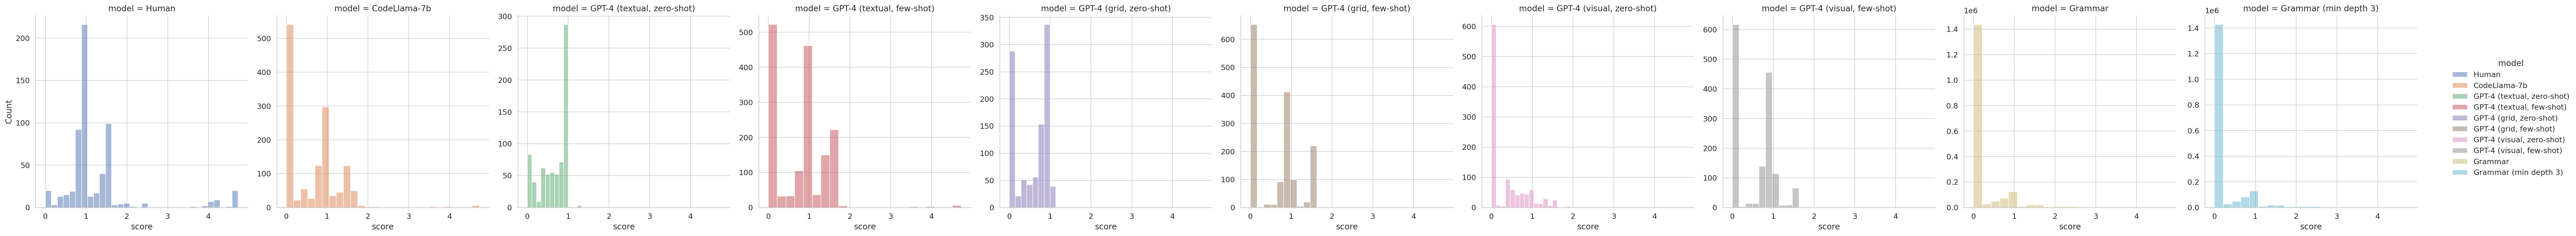

In [83]:
sns.displot(
    data=df_1,
    col="model",
    x="score",
    hue="model",
    common_norm=False,
    common_bins=False,
    facet_kws=dict(sharey=False)
)

### Grouped by trial

Text(0, 0.5, 'EIG')

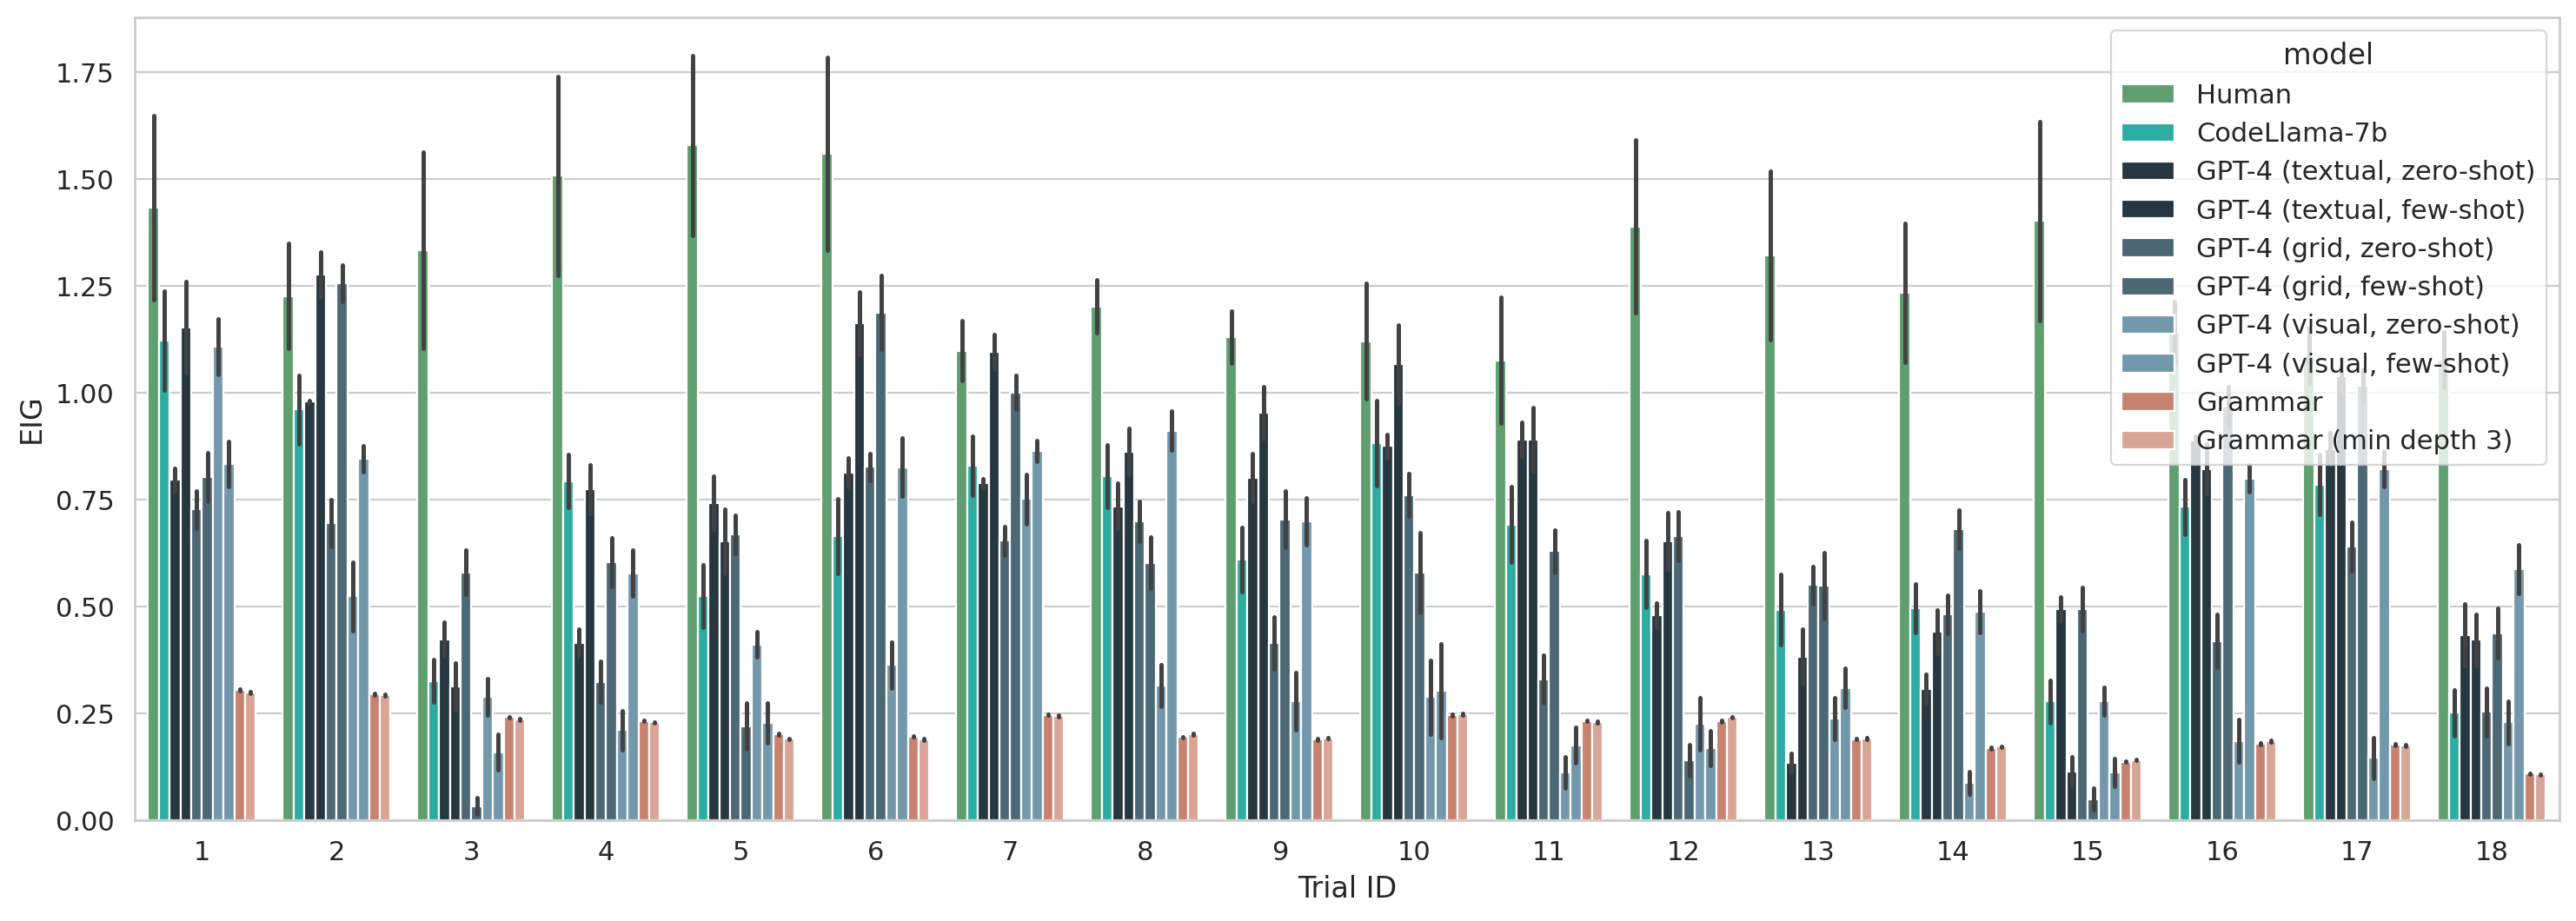

In [84]:
plt.figure(figsize=(18, 6))
sns.barplot(data=df_1, hue="model", x="trial_id", y="score", errorbar="se", palette=PALETTE)
plt.xlabel("Trial ID")
plt.ylabel("EIG")

Text(0, 0.5, 'EIG')

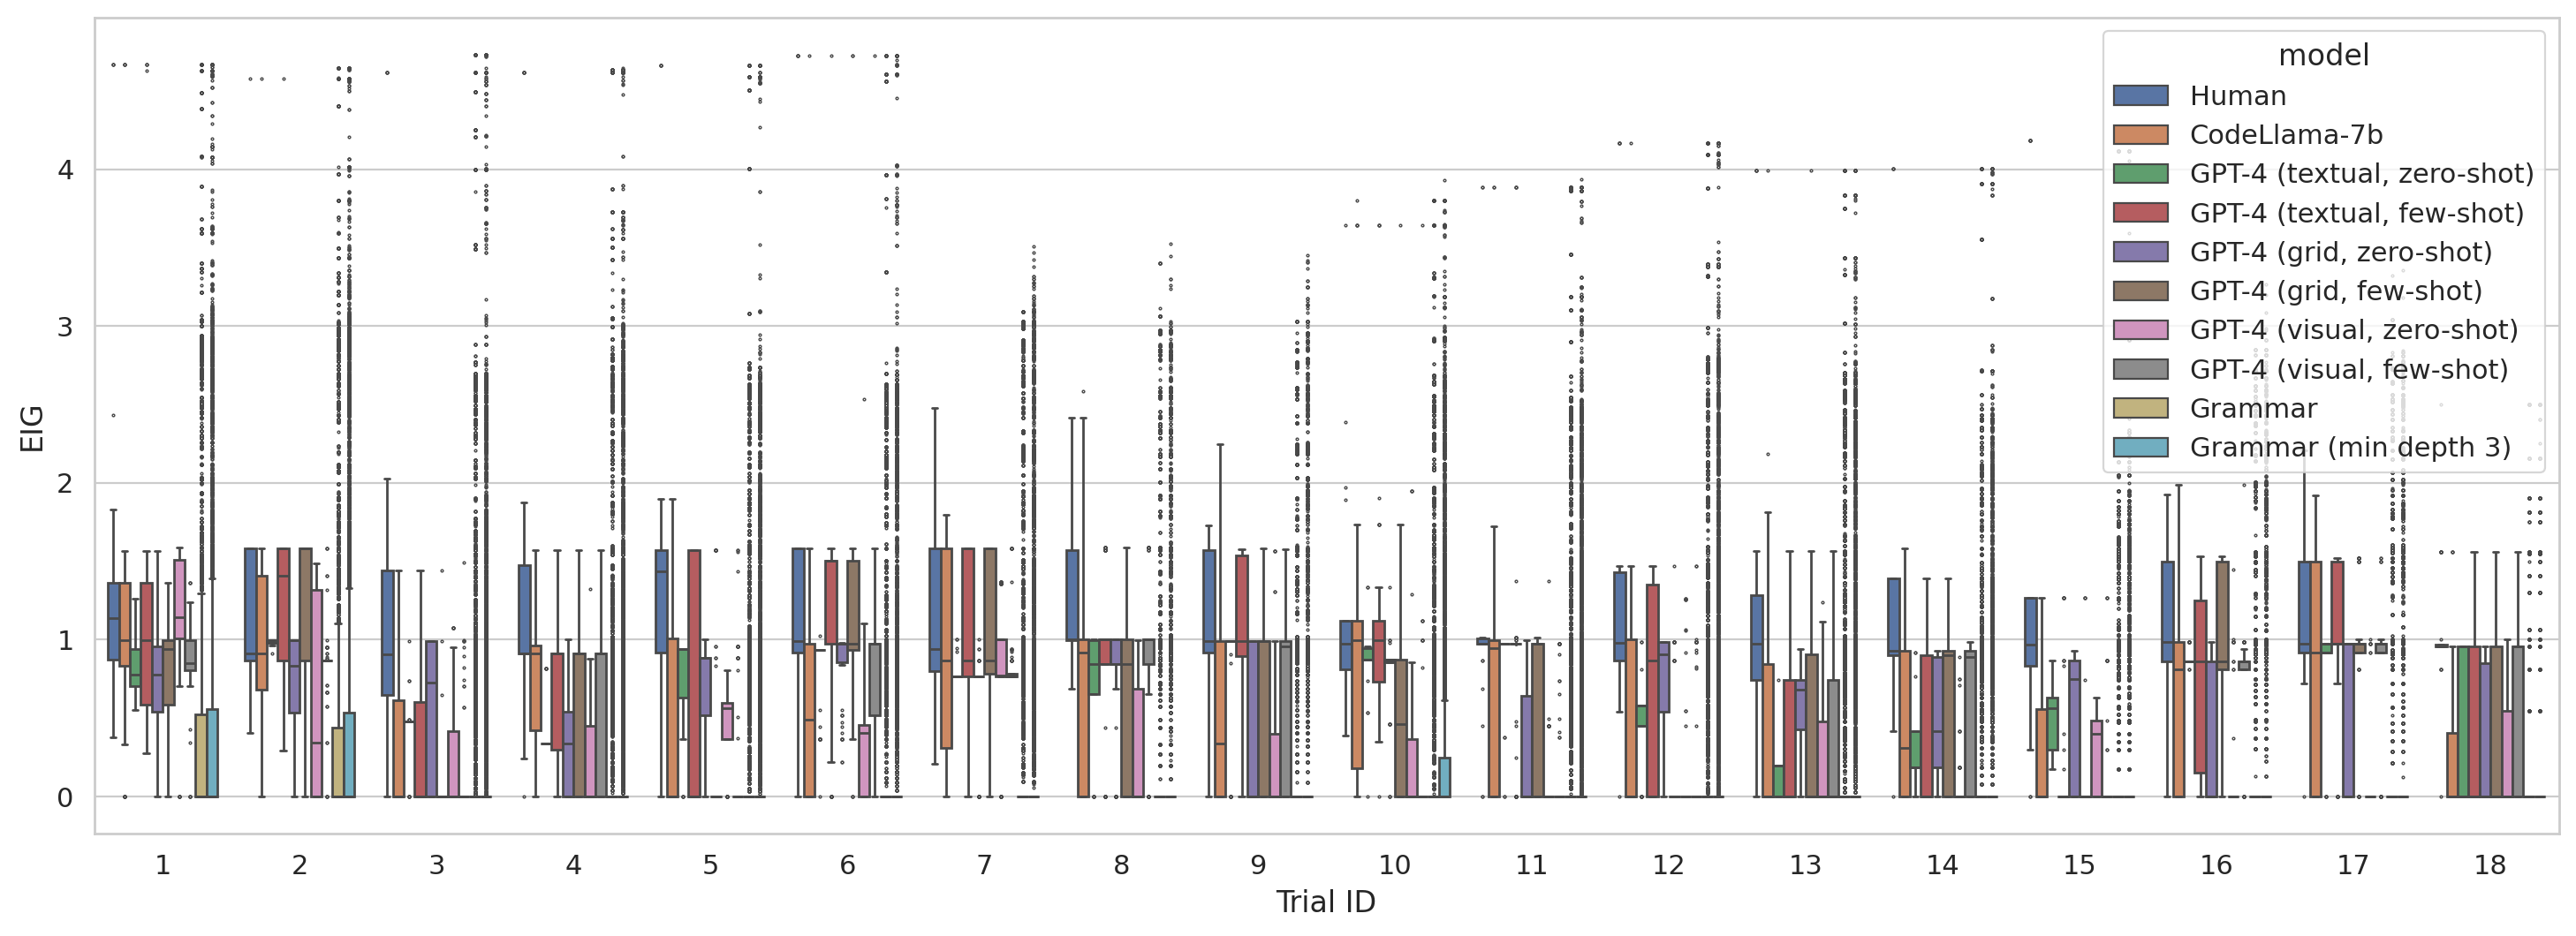

In [85]:
plt.figure(figsize=(18, 6))
# sns.boxplot(data=df, hue="model", x="trial_id", y="score", showfliers=False)
sns.boxplot(
    data=df_1,
    hue="model",
    x="trial_id",
    y="score",
    fliersize=1.0,
    flierprops={"marker": "."},
)
plt.xlabel("Trial ID")
plt.ylabel("EIG")

### EIG Percentile

In [86]:
data = []

human_scores = df_human.score.fillna(value=0).values

for (model, k, trial_id), df_group in df.groupby(["model", "k", "trial_id"]):
    scores = df_group.score.fillna(value=0).values
    for i in range(101):
        percentile_of_model = np.percentile(scores, i)
        percentile_of_human = percentileofscore(human_scores, percentile_of_model).item()
        data.append(
            {
                "model": model,
                "k": k,
                "trial_id": trial_id,
                "percentile": i,
                "score": percentile_of_model,
                "percentile_human": percentile_of_human,
            }
        )

df_eig_sum = pd.DataFrame(data)

In [87]:
df_eig_sum

model  k  trial_id  percentile     score  percentile_human
0      CodeLlama-7b  1         1           0  0.000000          1.735537
1      CodeLlama-7b  1         1           1  0.000000          1.735537
2      CodeLlama-7b  1         1           2  0.000000          1.735537
3      CodeLlama-7b  1         1           3  0.000000          1.735537
4      CodeLlama-7b  1         1           4  0.000000          1.735537
...             ... ..       ...         ...       ...               ...
83623         Human  1        18          96  1.561278         79.173554
83624         Human  1        18          97  1.561278         79.173554
83625         Human  1        18          98  1.842895         91.074380
83626         Human  1        18          99  2.171447         92.396694
83627         Human  1        18         100  2.500000         93.388430

[83628 rows x 6 columns]

Text(0, 0.5, 'EIG')

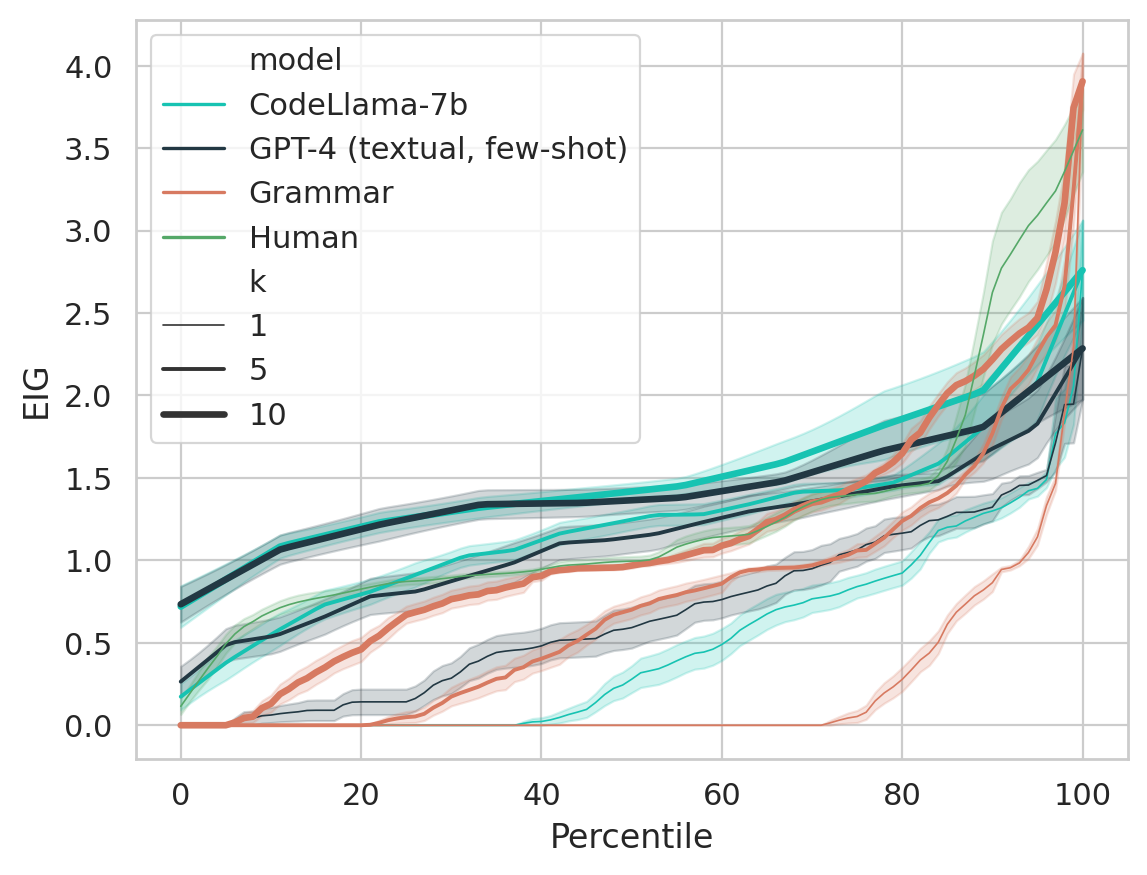

In [88]:
# plt.figure(figsize=(12, 8))
models = ["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Human", "Grammar"]
sns.lineplot(
    data=df_eig_sum[(df_eig_sum["k"] <= 10) & (df_eig_sum["model"].isin(models))],
    x="percentile",
    y="score",
    hue="model",
    size="k",
    errorbar="se",
    palette=PALETTE,
)
plt.xlabel("Percentile")
plt.ylabel("EIG")

Text(1699.896111111111, 0.5, 'EIG')

<Figure size 1200x800 with 0 Axes>

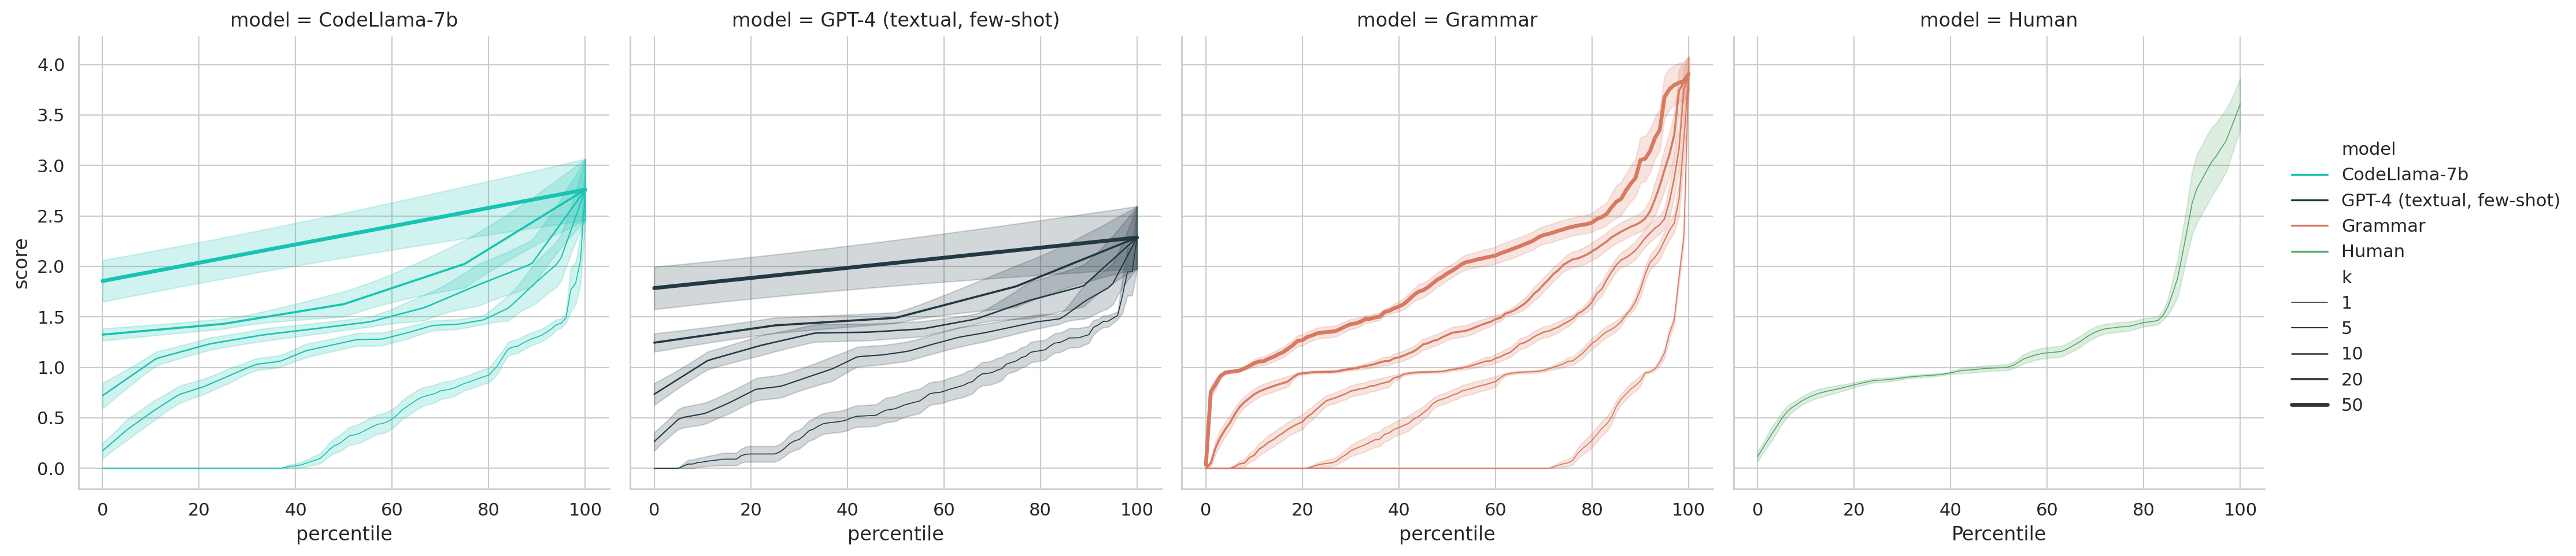

In [89]:
plt.figure(figsize=(12, 8))
models = ["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Human", "Grammar"]
sns.relplot(
    kind="line",
    col="model",
    data=df_eig_sum[(df_eig_sum["k"] <= 100) & (df_eig_sum["model"].isin(models))],
    x="percentile",
    y="score",
    hue="model",
    size="k",
    errorbar="se",
    palette=PALETTE,
)
plt.xlabel("Percentile")
plt.ylabel("EIG")

Text(0, 0.5, 'Percentile of Human')

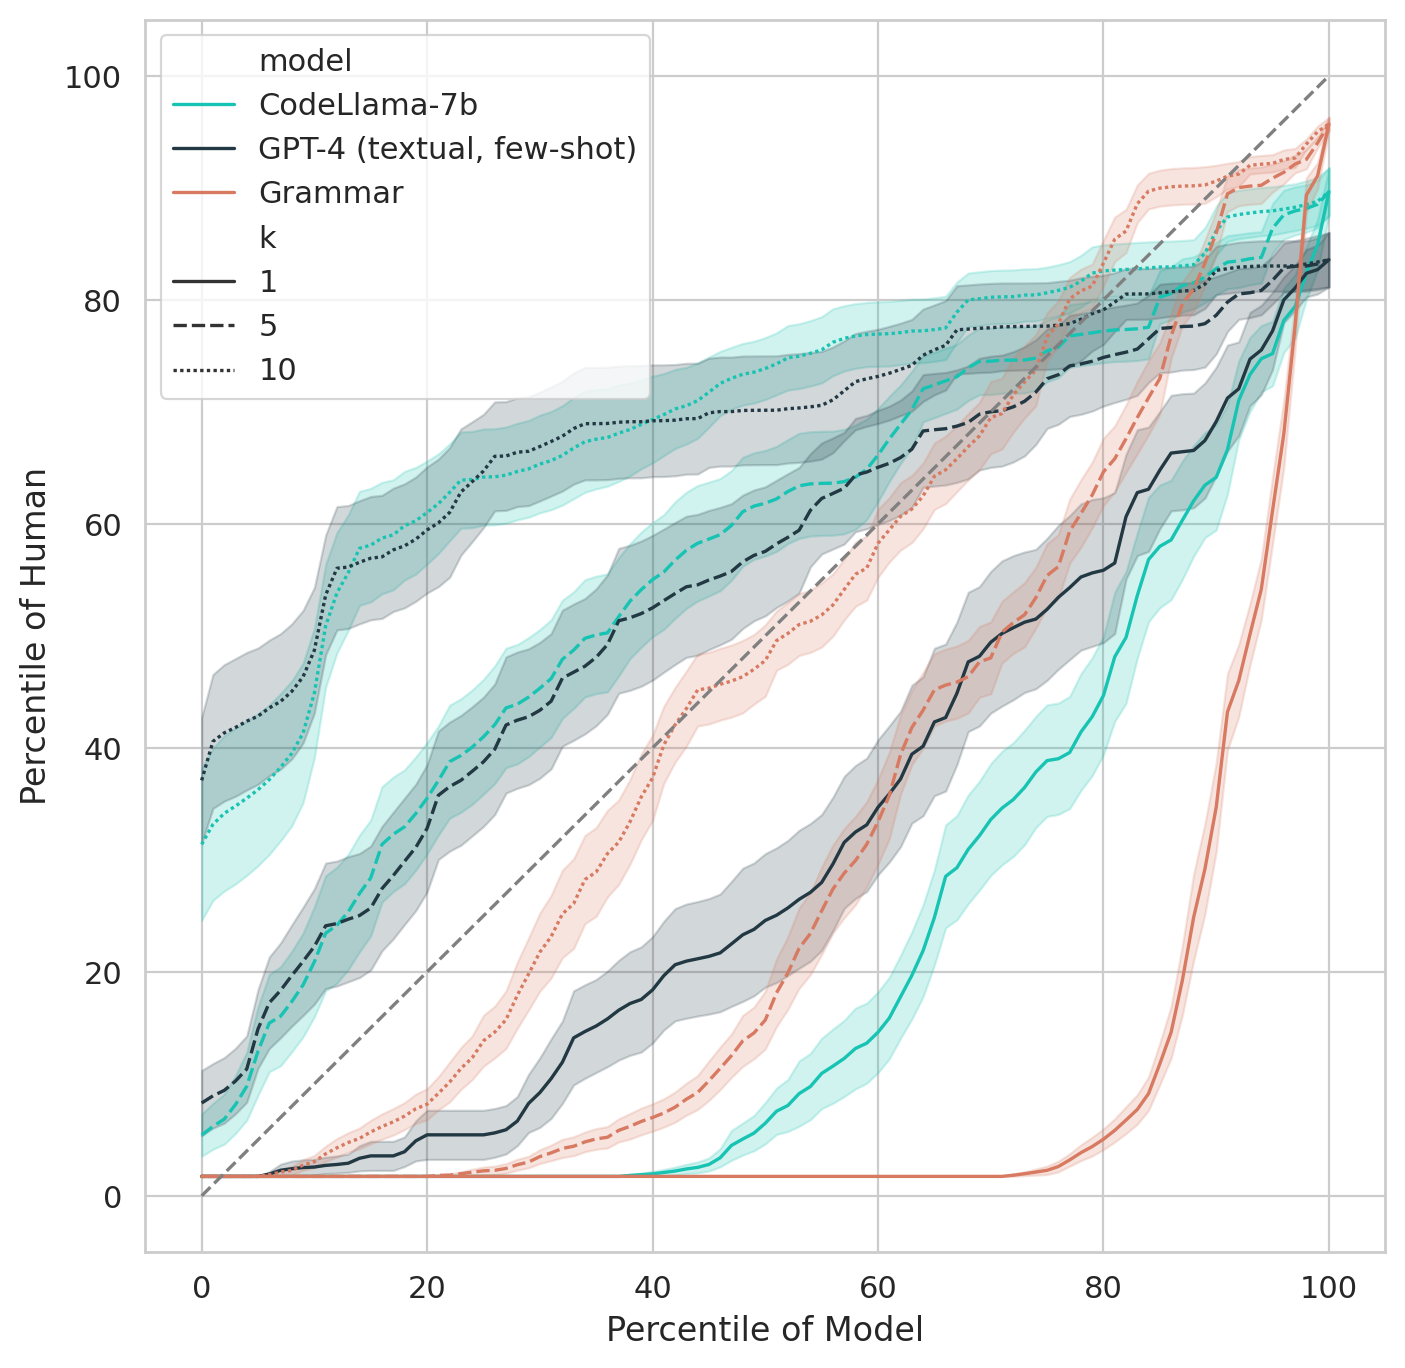

In [90]:
plt.figure(figsize=(8, 8))
models = ["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Grammar"]
sns.lineplot(
    data=df_eig_sum[(df_eig_sum["k"] <= 10) & (df_eig_sum["model"].isin(models))],
    x="percentile",
    y="percentile_human",
    hue="model",
    style="k",
    errorbar="se",
    palette=PALETTE,
)

# Draw diagonal line
x = np.linspace(0, 100, 100)
plt.plot(x, x, color="gray", linestyle="--")

plt.xlabel("Percentile of Model")
plt.ylabel("Percentile of Human")

<Figure size 800x800 with 0 Axes>

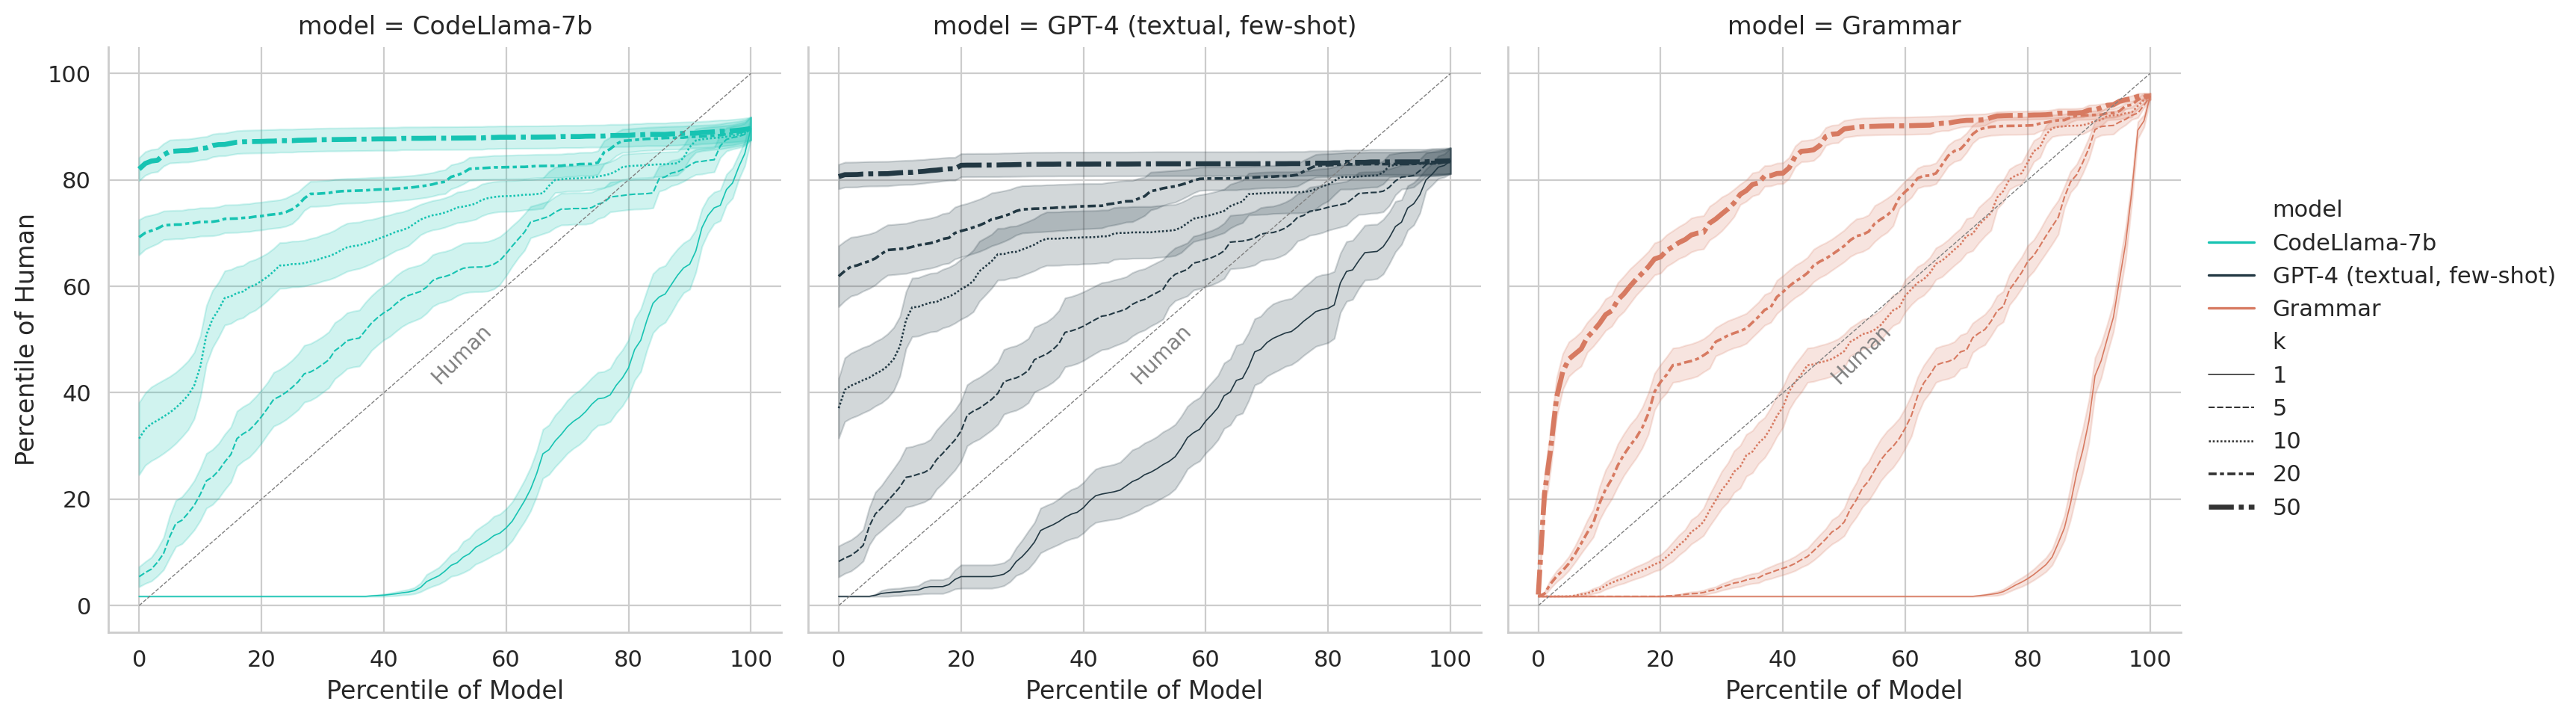

In [91]:
plt.figure(figsize=(8, 8))
models = ["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Grammar"]
sns.relplot(
    kind="line",
    data=df_eig_sum[(df_eig_sum["k"] <= 100) & (df_eig_sum["model"].isin(models))],
    col="model",
    x="percentile",
    y="percentile_human",
    hue="model",
    size="k",
    style="k",
    errorbar="se",
    palette=PALETTE,
)


for ax in plt.gcf().axes:

    # Draw diagonal line on all plots
    x = np.linspace(0, 100, 100)
    ax.plot(x, x, color="gray", linestyle="--", linewidth=0.5)

    # Label the line diagonally
    ax.text(
        0.525,
        0.475,
        "Human",
        color="gray",
        fontsize=10,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        rotation=45,
    )

    ax.set_xlabel("Percentile of Model")
    ax.set_ylabel("Percentile of Human")


## General EIG dists

Text(0, 0.5, 'EIG')

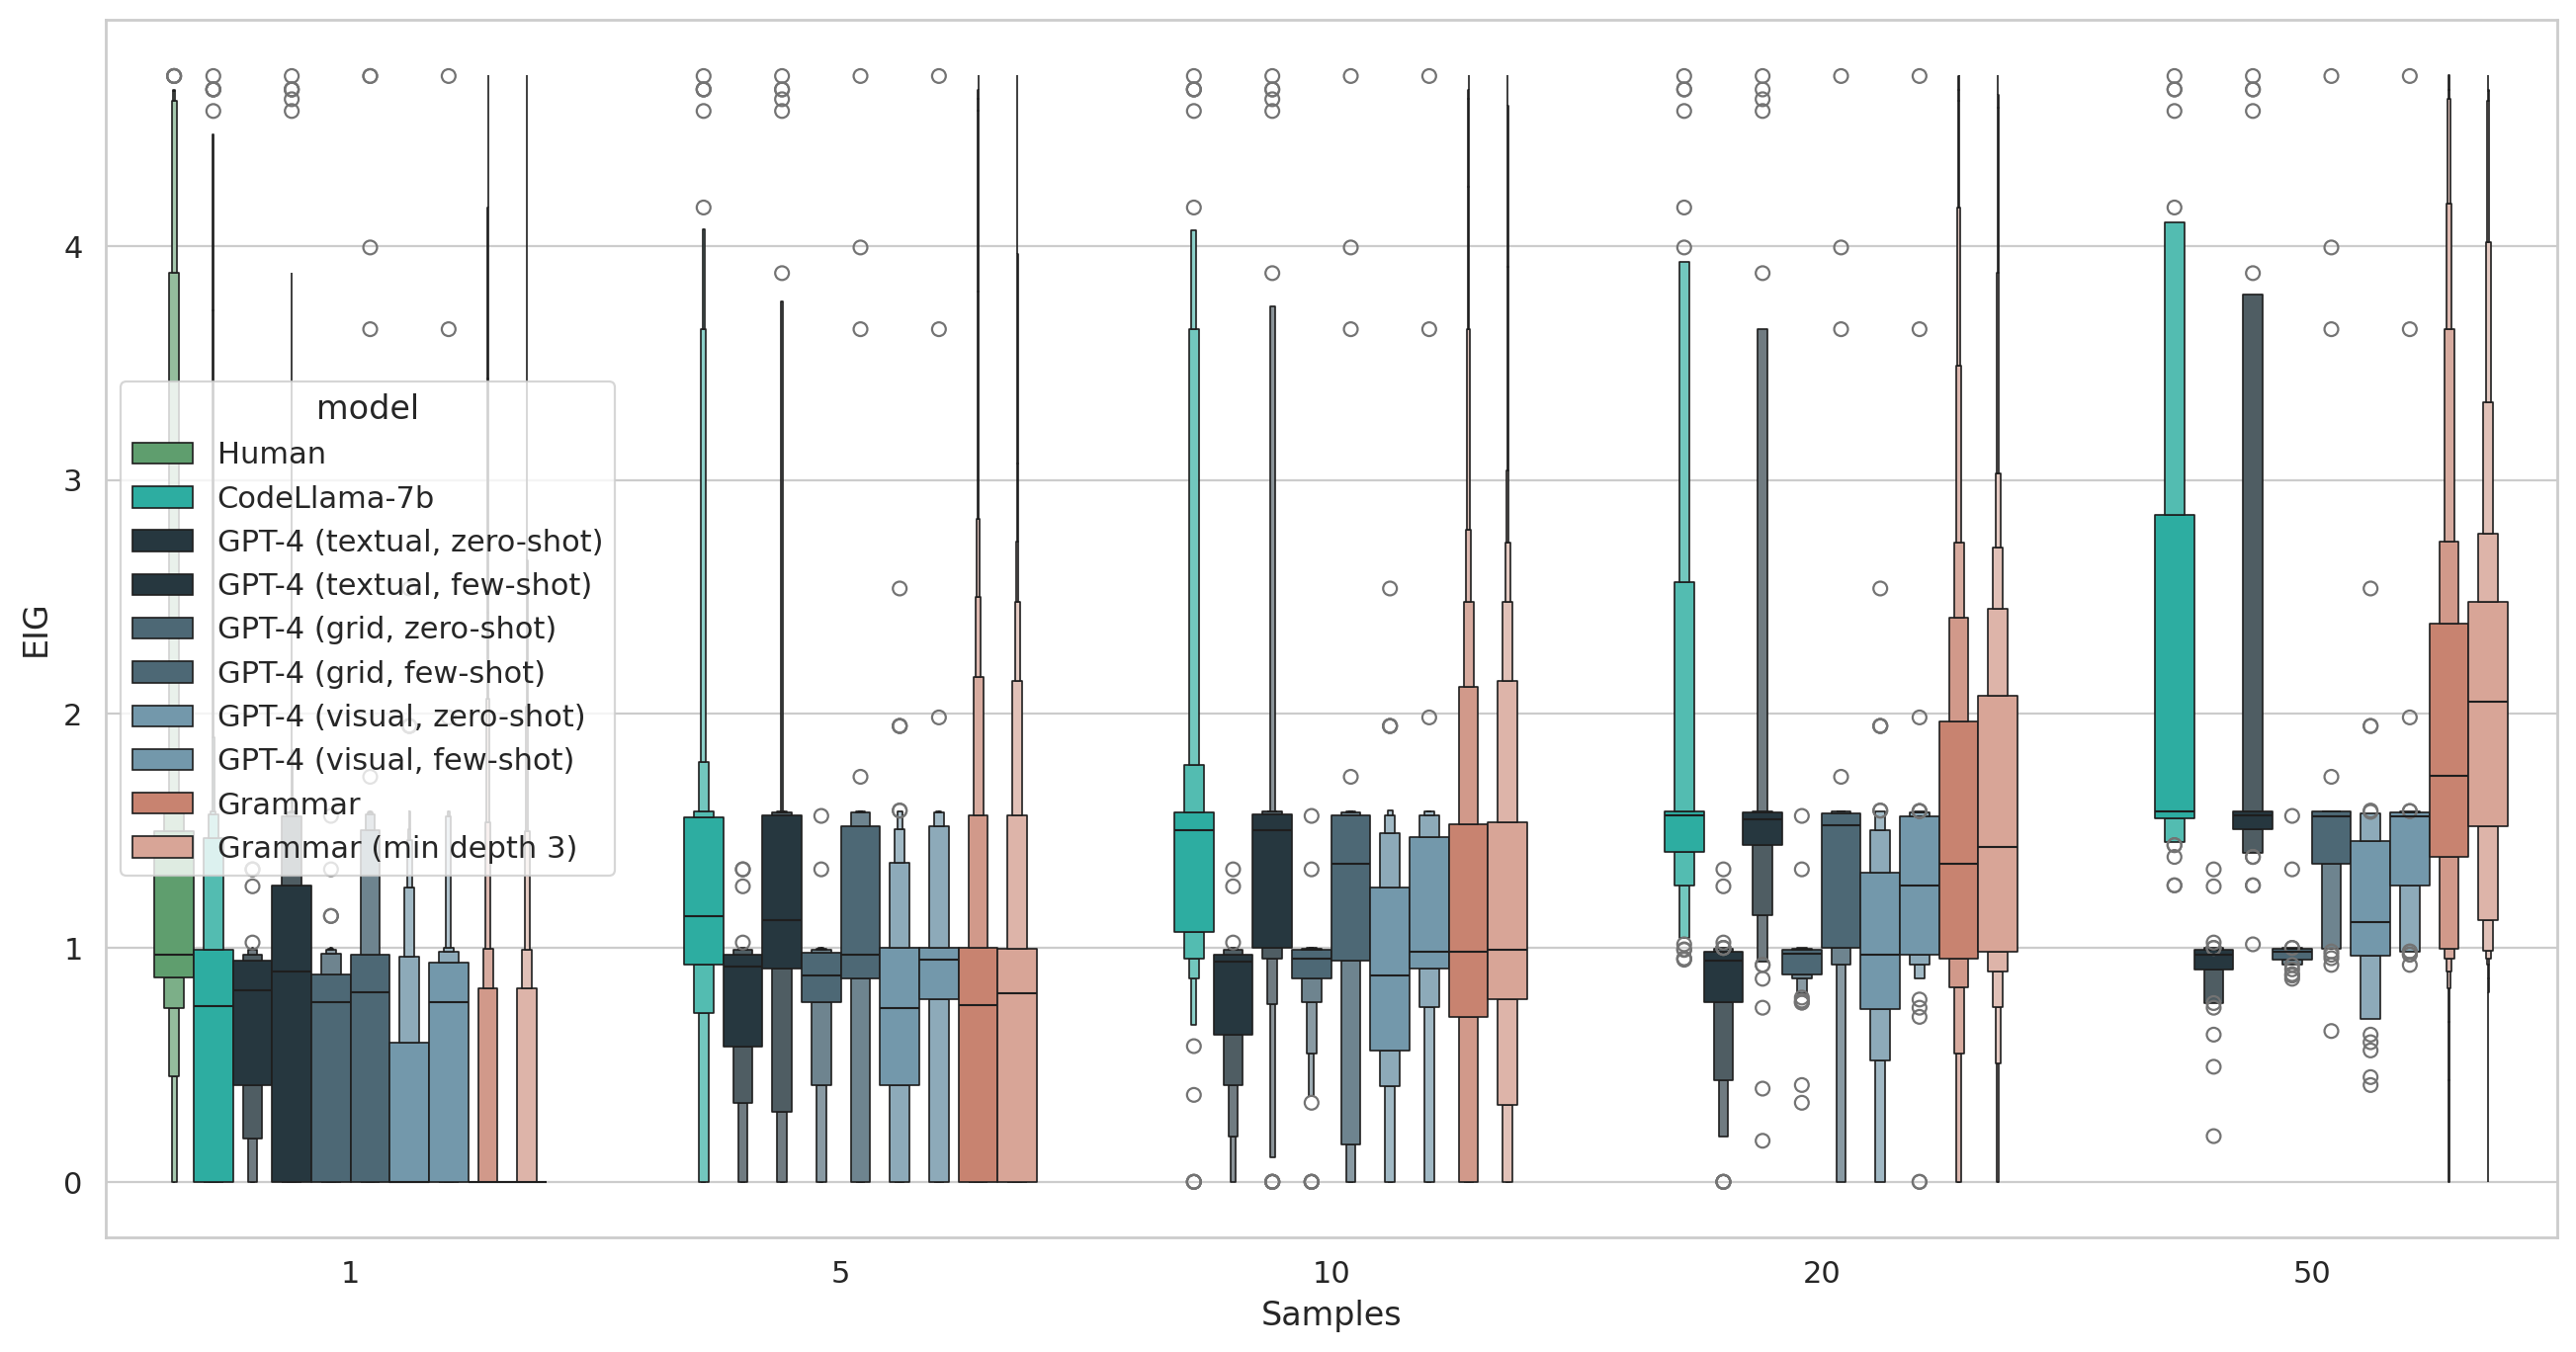

In [92]:
plt.figure(figsize=(16, 8))
# sns.pointplot(data=df, x="k", y="score", hue="model", errorbar="se")
sns.boxenplot(data=df, x="k", y="score", hue="model", palette=PALETTE)
plt.xlabel("Samples")
plt.ylabel("EIG")
# plt.xscale("log")

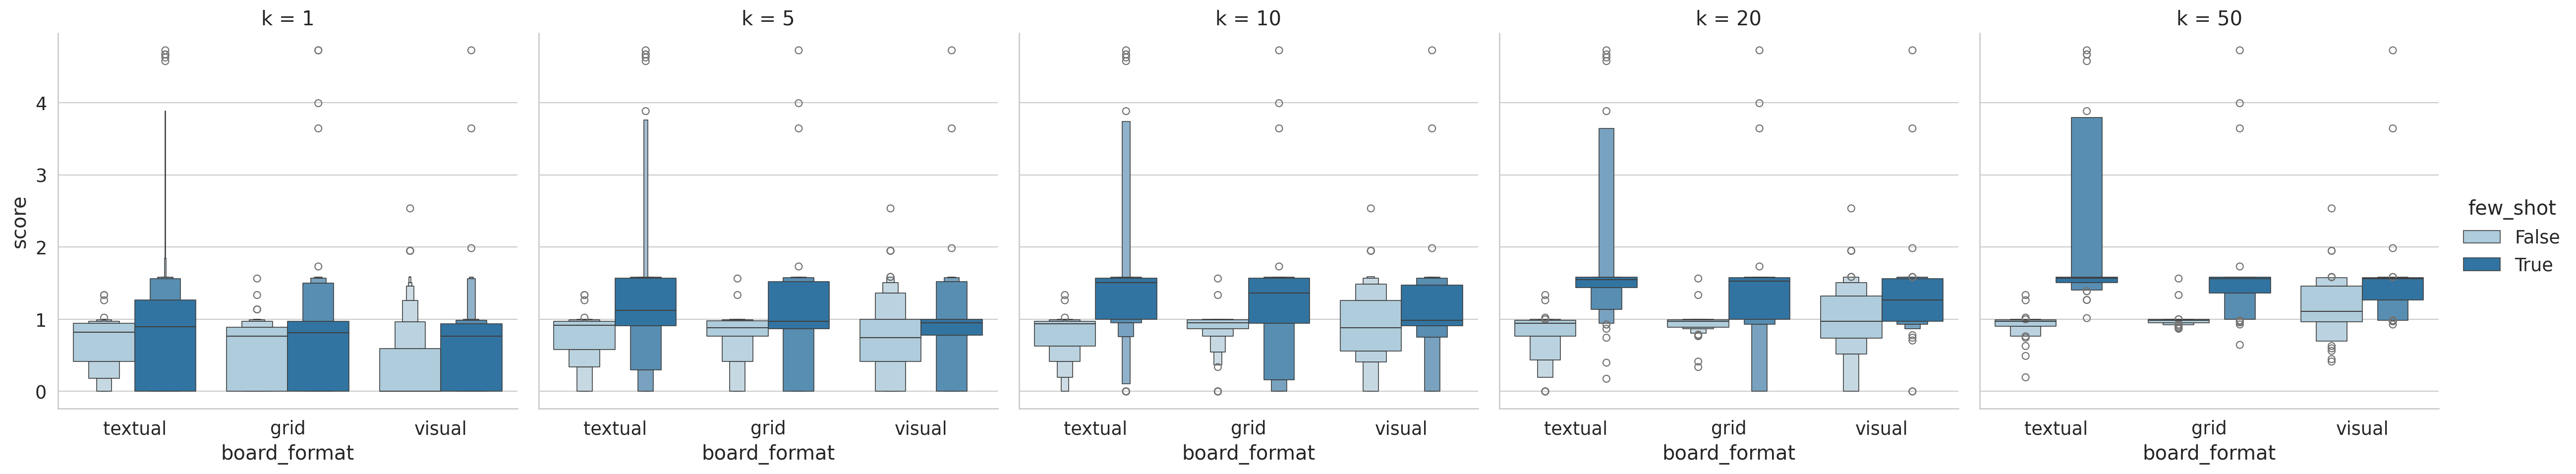

In [93]:
with sns.plotting_context("paper", font_scale=1.5):
    # plt.figure(figsize=(16, 8))

    # neutral 2-color binary palette
    palette = sns.color_palette("Paired", 2)

    sns.catplot(
        kind="boxen",
        data=df[df.model.str.contains("GPT-4")],
        x="board_format",
        y="score",
        hue="few_shot",
        col="k",
        palette=palette,
    )
    # plt.xlabel("Samples")
    plt.ylabel("EIG")

Text(0, 0.5, 'Expected Information Gain (EIG)')

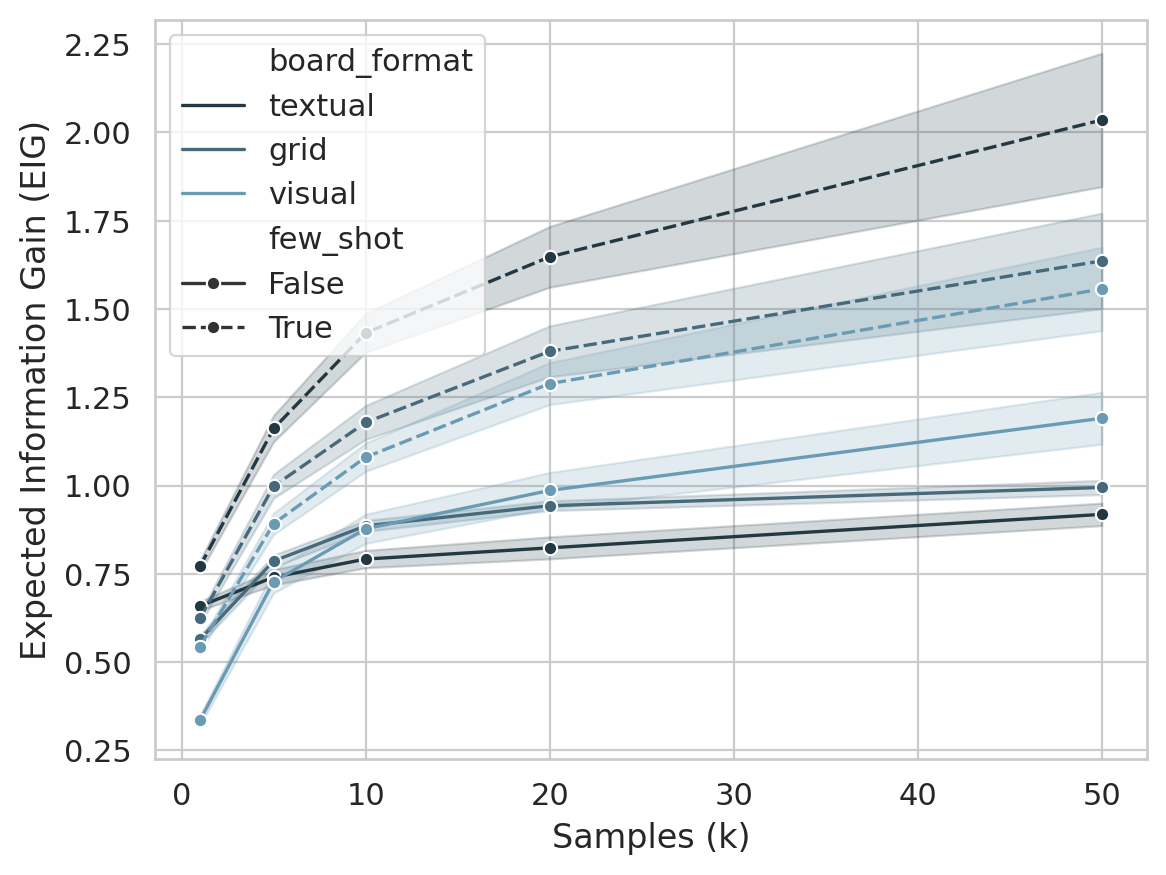

In [95]:
# plt.figure(figsize=(16, 8))

# textual / grid / visual palette
palette = sns.color_palette([COLOR_TEXTUAL, COLOR_GRID, COLOR_VISUAL], n_colors=3)

sns.lineplot(
    data=df[df.model.str.contains("GPT-4")],
    x="k",
    y="score",
    hue="board_format",
    style="few_shot",
    markers=["o", "o"],
    errorbar="se",
    palette=palette,
)
plt.xlabel("Samples (k)")
plt.ylabel("Expected Information Gain (EIG)")
# plt.xscale("log")

In [96]:
human_mean = df[df.model == "Human"].groupby("trial_id").score.mean().mean()
print(f"Human mean: {human_mean:.3f}")

human_max = df[df.model == "Human"].groupby("trial_id").score.max().mean()
print(f"Human max: {human_max:.3f}")

Human mean: 1.274
Human max: 3.611


Text(0, 0.5, 'Expected Information Gain (EIG)')

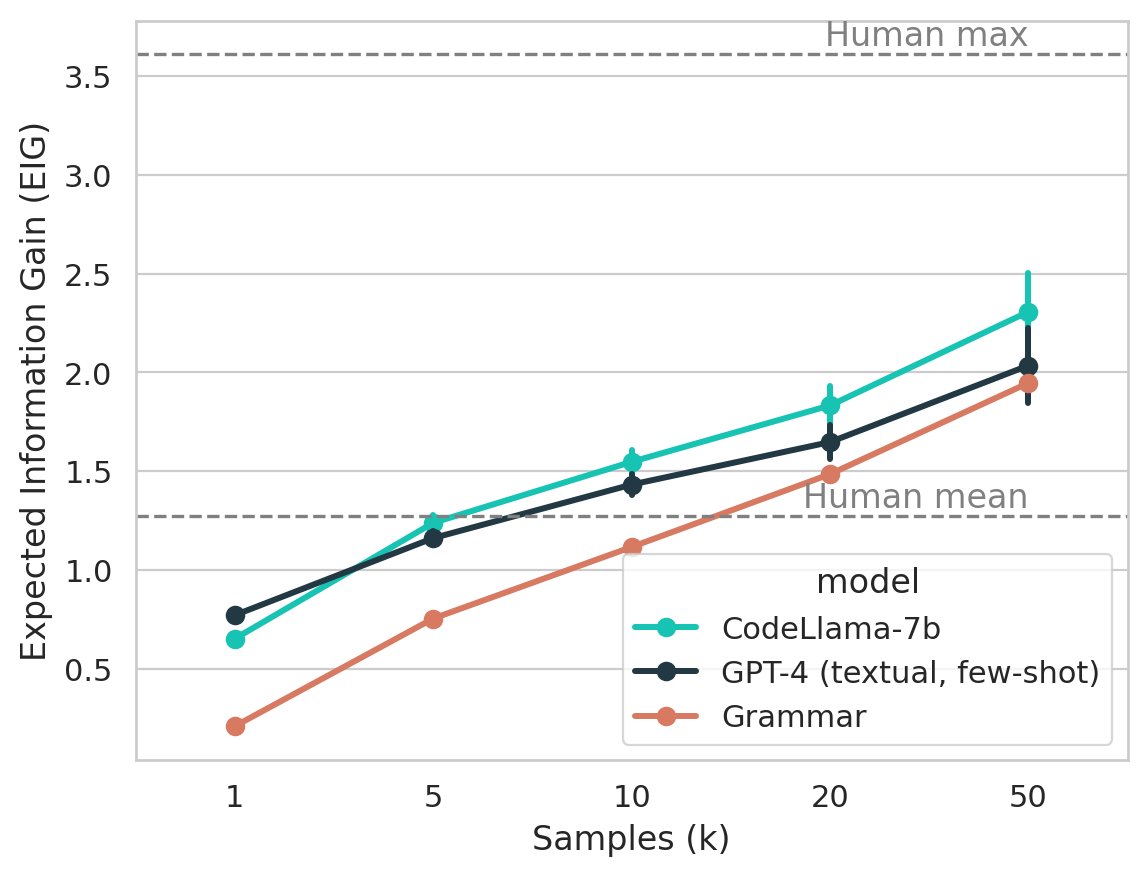

In [97]:
# plt.figure(figsize=(16, 8))

# sns.lineplot(data=df[df.model != "Human"], x="k", y="score", hue="model", errorbar="se", palette=PALETTE)
# sns.pointplot(data=df[df.model != "Human"], x="k", y="score", hue="model", errorbar="se", palette=PALETTE)
sns.pointplot(
    data=df[df.model.isin(["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Grammar"])],
    x="k",
    y="score",
    hue="model",
    errorbar="se",
    palette=PALETTE,
)


# Add lines for human mean and max
plt.axhline(human_mean, color="gray", linestyle="--")
plt.axhline(human_max, color="gray", linestyle="--")

# Add labels for human mean and max
plt.text(4, human_mean + 0.01, "Human mean", ha="right", va="bottom", color="gray")
plt.text(4, human_max + 0.01, "Human max", ha="right", va="bottom", color="gray")


plt.xlabel("Samples (k)")
plt.ylabel("Expected Information Gain (EIG)")
# plt.xscale("log")

Text(0, 0.5, 'Expected Information Gain (EIG)')

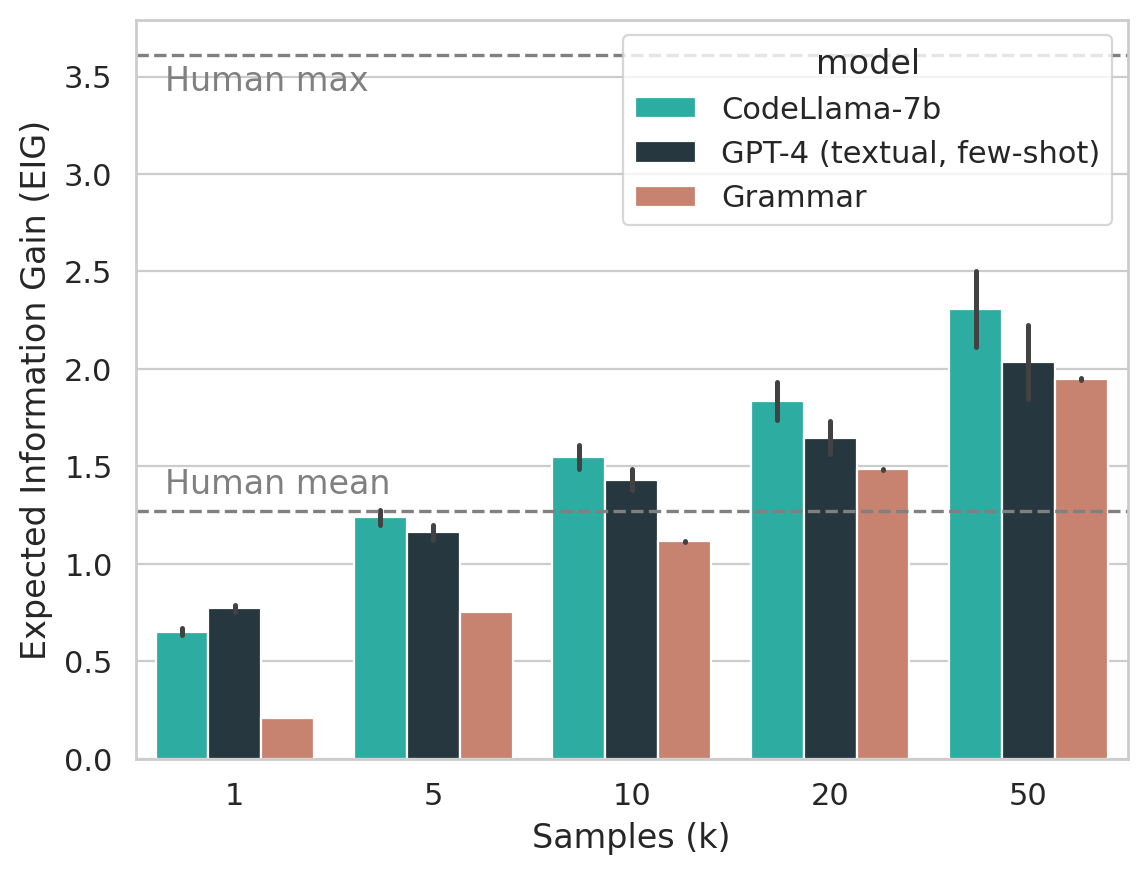

In [105]:
# plt.figure(figsize=(16, 8))

# sns.boxplot(data=df[df.model != "Human"], x="k", y="score", hue="model", palette=PALETTE, showfliers=False)
sns.barplot(
    data=df[df.model.isin(["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Grammar"])],
    x="k",
    y="score",
    hue="model",
    palette=PALETTE,
    errorbar="se",
)


# Add lines for human mean and max
plt.axhline(human_mean, color="gray", linestyle="--")
plt.axhline(human_max, color="gray", linestyle="--")

# Add labels for human mean and max
plt.text(-0.35, human_mean + 0.05, "Human mean", ha="left", va="bottom", color="gray")
plt.text(-0.35, human_max - 0.05, "Human max", ha="left", va="top", color="gray")


plt.xlabel("Samples (k)")
plt.ylabel("Expected Information Gain (EIG)")

plt.savefig(os.path.join(FIGURES_DIR, "eig_vs_k.pdf"), bbox_inches="tight")

In [104]:
df.sort_values("score", ascending=False).head(100)

trial_id question                                            program  \
2058226         3      NaN                   ( == ( color 3D ) ( color 4A ) )   
4889112         3      NaN              ( and ( == V H ) ( == ( - 6 7 ) 8 ) )   
2058482         3      NaN                                  ( not ( > 2 4 ) )   
3714518         3      NaN                                                 3A   
4889045         3      NaN             ( == 5 ( + ( rowL 4F ) ( rowL 5F ) ) )   
...           ...      ...                                                ...   
4726234         3      NaN  ( == ( or ( and ( > ( rowL 2E ) 4 ) ( touch Bl...   
4726282         3      NaN                 ( setSize ( coloredTiles Water ) )   
4726322         3      NaN                   ( bottomright ( set AllTiles ) )   
4726327         3      NaN                   ( bottomright ( set AllTiles ) )   
3717126         3      NaN                          ( == Water ( color 3B ) )   

            score                  model type  prompt_id   k board_format  \
2058226  4.731494  Grammar (min depth 3)  NaN        NaN   1          NaN   
4889112  4.731494  Grammar (min depth 3)  NaN        NaN  50          NaN   
2058482  4.731494  Grammar (min depth 3)  NaN        NaN   1          NaN   
3714518  4.731494                Grammar  NaN        NaN   5          NaN   
4889045  4.731494  Grammar (min depth 3)  NaN        NaN  50          NaN   
...           ...                    ...  ...        ...  ..          ...   
4726234  4.731494  Grammar (min depth 3)  NaN        NaN  20          NaN   
4726282  4.731494  Grammar (min depth 3)  NaN        NaN  20          NaN   
4726322  4.731494  Grammar (min depth 3)  NaN        NaN  20          NaN   
4726327  4.731494  Grammar (min depth 3)  NaN        NaN  20          NaN   
3717126  4.731494                Grammar  NaN        NaN   5          NaN   

        few_shot  depth  min_depth  max_depth  
2058226      NaN    3.0        3.0       16.0  
4889112      NaN    4.0        3.0       16.0  
2058482      NaN    4.0        3.0       16.0  
3714518      NaN    1.0        1.0       16.0  
4889045      NaN    4.0        3.0       16.0  
...          ...    ...        ...        ...  
4726234      NaN    6.0        3.0       16.0  
4726282      NaN    3.0        3.0       16.0  
4726322      NaN    3.0        3.0       16.0  
4726327      NaN    6.0        3.0       16.0  
3717126      NaN    1.0        1.0       16.0  

[100 rows x 13 columns]

# Grammar

<Axes: xlabel='depth', ylabel='Probability'>

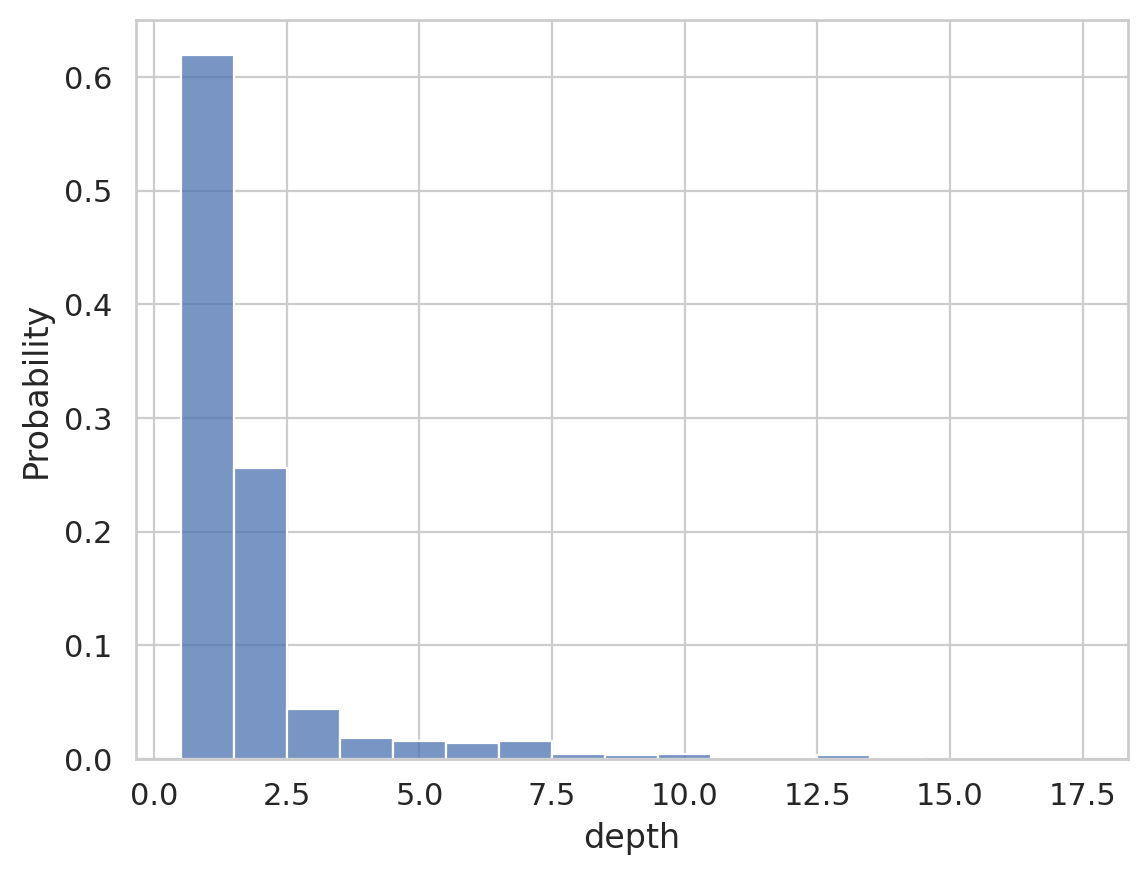

In [100]:
sns.histplot(df[df.model == "Grammar"].depth, stat="probability", discrete=True)

In [101]:
df[df.model == "Grammar"].sort_values("depth", ascending=True).program.tolist()[:100]

['1A',
 '0',
 '( rowL 1A )',
 '6B',
 '( orient Purple )',
 'Purple',
 'V',
 '( size Blue )',
 'H',
 '2',
 'V',
 '6C',
 '8',
 '2D',
 '( == ( orient Red ) ( orient Red ) )',
 'H',
 'Water',
 '4B',
 '( == Blue Water )',
 'H',
 'Purple',
 '5F',
 '2C',
 'Water',
 '( orient Purple )',
 '5F',
 'TRUE',
 'V',
 'H',
 '4A',
 '2E',
 'Water',
 'V',
 '( orient Blue )',
 '( color 5B )',
 'Purple',
 '5',
 '7',
 'V',
 '3F',
 'V',
 '( == ( orient Red ) ( orient Red ) )',
 '( color 3D )',
 '( color 6E )',
 'Purple',
 '( isSubset ( unique ( coloredTiles Water ) ) ( set AllTiles ) )',
 'H',
 'H',
 '3C',
 'V',
 'Red',
 '1C',
 'Water',
 'Blue',
 '( colL 1F )',
 '5C',
 '3',
 'Red',
 '6B',
 '( color 3A )',
 '7',
 '9',
 'H',
 'TRUE',
 '5',
 'V',
 'TRUE',
 'Water',
 'V',
 'FALSE',
 '8',
 '1A',
 '( color 2C )',
 '5',
 '5A',
 '7',
 'V',
 'Water',
 'H',
 'Water',
 '1B',
 'Water',
 '7',
 'Water',
 'H',
 '0',
 '7',
 '( orient Purple )',
 '0',
 '( orient Purple )',
 '6',
 'Water',
 '4',
 '( not FALSE )',
 'V',
 '4A',


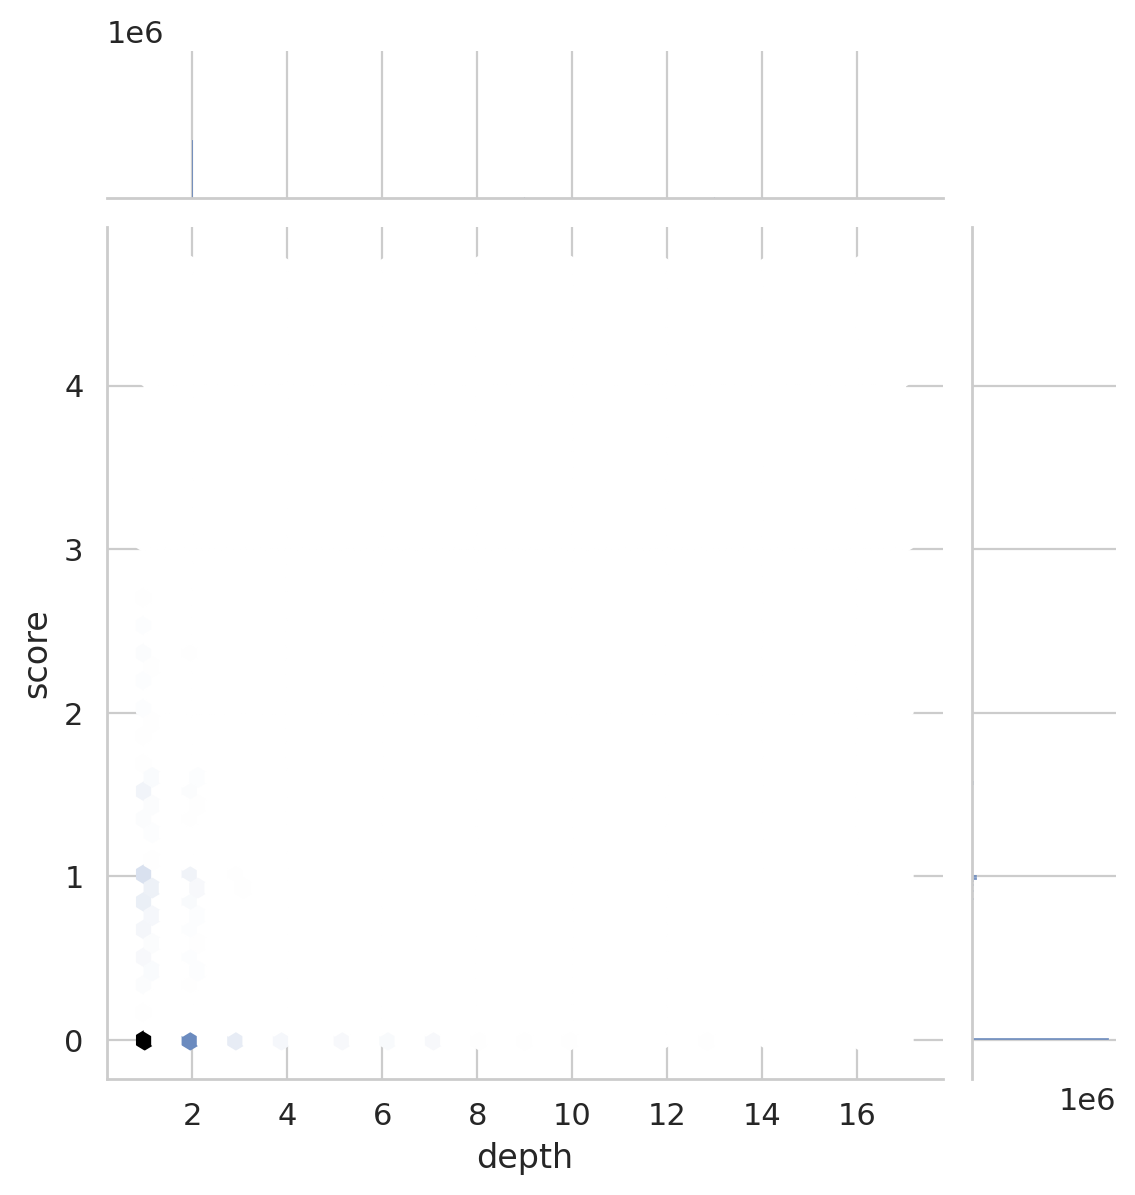

In [102]:
sns.jointplot(data=df[df.model == "Grammar"], x="depth", y="score", kind="hex")